In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,UpSampling2D,Activation
from tensorflow.keras.layers import Subtract,BatchNormalization,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
noise_data = []
path1 = "/content/drive/MyDrive/Motion Artifact/Noisy/"
files = os.listdir(path1)
for i in tqdm(files):
    img = cv2.imread(path1 + '/'+i, 0)
    img = cv2.resize(img,(224,224))
    noise_data.append(img_to_array(img))

100%|██████████| 1000/1000 [00:09<00:00, 109.85it/s]


In [3]:
clean_data = []
path2 = "/content/drive/MyDrive/Motion Artifact/Normal_1000"
files = os.listdir(path2)
for i in tqdm(files):
    img = cv2.imread(path2 + '/'+i, 0)
    img = cv2.resize(img,(224,224))
    clean_data.append(img_to_array(img))

100%|██████████| 1000/1000 [00:09<00:00, 105.49it/s]


In [4]:
noisy_train = np.reshape(noise_data,(len(noise_data),224,224,1))
noisy_train = noisy_train.astype('float32')/255.

clean_train = np.reshape(clean_data,(len(clean_data),224,224,1))
clean_train = clean_train.astype('float32')/255.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(noisy_train, clean_train, 
                                                    test_size = 0.20, random_state = 0)

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(800, 224, 224, 1)
(800, 224, 224, 1)
(200, 224, 224, 1)
(200, 224, 224, 1)


In [18]:
input_layer = Input(shape=(224, 224, 1))

x = Conv2D(16, (3,3), activation='relu', padding='same', strides=2)(input_layer)
x = Conv2D(8, (3,3), activation='relu', padding='same', strides=2)(x)

x = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(x)

output_layer = Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')(x)
model = Model(inputs = input_layer,outputs = output_layer)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 16)      160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 8)         1160      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 112, 112, 8)       584       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 224, 224, 16)      1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 1)       145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
___________________________________________________________

In [24]:
model.compile(optimizer='adam', loss='mse')

In [25]:
model.fit(x_train, 
                y_train, 
                epochs=10, 
                shuffle=True)

Epoch 1/10
25/25 [==============================] - 3s 79ms/step - loss: 0.0512
Epoch 2/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0508
Epoch 3/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0510
Epoch 4/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0508
Epoch 5/10
25/25 [==============================] - 2s 75ms/step - loss: 0.0507
Epoch 6/10
25/25 [==============================] - 2s 74ms/step - loss: 0.0507
Epoch 7/10
25/25 [==============================] - 2s 77ms/step - loss: 0.0506
Epoch 8/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0509
Epoch 9/10
25/25 [==============================] - 2s 75ms/step - loss: 0.0510
Epoch 10/10
25/25 [==============================] - 2s 76ms/step - loss: 0.0510


In [26]:
no_noise_img = model.predict(x_test)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbf3de38350>,
 Text(0.5, 1.0, 'denoised'))

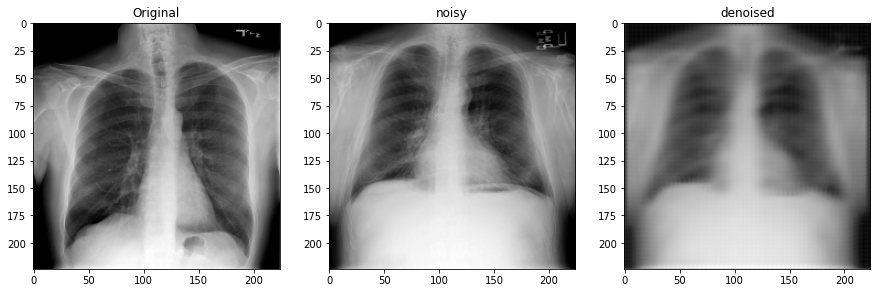

In [30]:
plt.figure(figsize=(15,12))
plt.subplot(131), plt.imshow(np.squeeze(y_test[3]), cmap="gray"),plt.title('Original')
plt.subplot(132), plt.imshow(np.squeeze(x_test[3]),cmap="gray"),plt.title('noisy')
plt.subplot(133), plt.imshow(np.squeeze(no_noise_img[3]),cmap="gray"),plt.title('denoised')

In [31]:
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
from scipy import ndimage as nd

noise_psnr = peak_signal_noise_ratio(y_test[3], x_test[3])
gaussian_cleaned_psnr = peak_signal_noise_ratio(y_test[3], no_noise_img[3])
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", gaussian_cleaned_psnr)

PSNR of input noisy image =  12.84776339021019
PSNR of cleaned image =  13.680167128690883
